## Single delayed inverted pendulum example

The parameters: `τ`=sqrt(2)/4 and b=1.5 (fixed). Parameter 'a' is varied.

In this demo, we will be looking at inverted pendulum example, which models the motion of a pendulum that is trying to remain upright. For this demo we'll use the simplified system given by the delay differential equation (DDE) system:
```math
\begin{align}
  \dot{x}&= v(t)\\
  \dot{v}&= \sin(x(t)) - ax(t- \tau) -bv(t-\tau)
\end{align}
```
where x(t) is the angle by the pendulum deviates from its upright positions, v(t) is the angular velocity and where τ is the delay is the time taken between the pendulum starting to fall/lean and the reaction to start righting the pendulum.

The following packages and functions are needed:

In [77]:
using CairoMakie
using LinearAlgebra
include("invpend_1delay.jl") #RHS of single delay inverted pendulum example
include("inpend1tau.jl") #Delay function for inverted pendulum example
include("f_deriv.jl") #used to find state and/or parameter derivatives
include("jacobian_new.jl") #Jacobian function
include("newton_new.jl") #Newton function
include("F_eq.jl") #Initialisates a function to find equilibria 
include("track_curve_new.jl") #Tracking curve function (used for continuation and equilibria branches)
include("stab_func.jl") #finds stability and eigenvalues (and eigenvector and ω is interested in Hopf bifurcation)
include("create_hopffunc.jl") #finds initial guess for Hopf information and creates a function that can find the true Hopf values
include("create_foldfunc.jl") #finds initial guess for fold information and creates a function that can find the true fold values

create_foldfunc (generic function with 2 methods)

# Equilibria branches

We begin this demo by finding the equilibira branches:

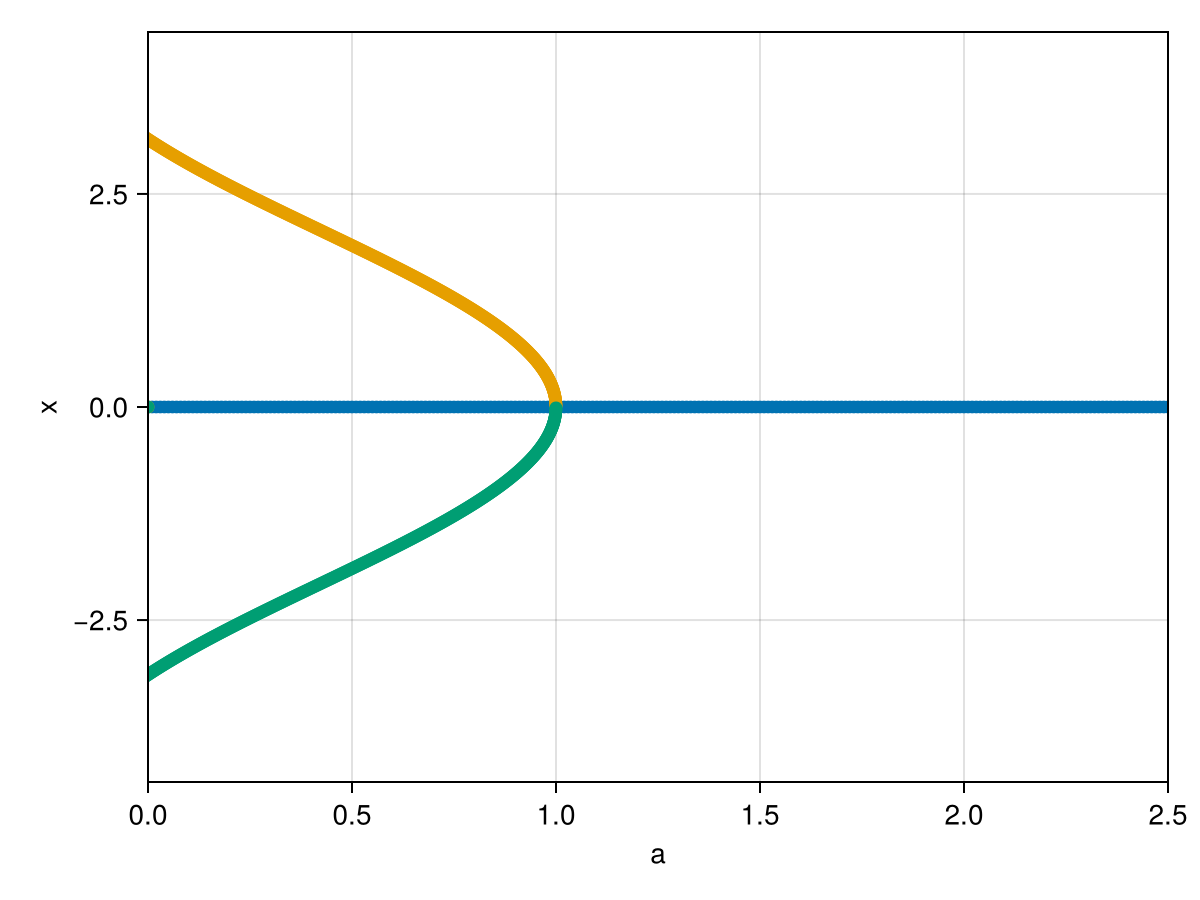

In [78]:
a=0.0 #parameter a - starts at 0 as this is the parameter we're varying over
b=1.5 #parameter b - fixed 
tau=sqrt(2)/4 #delay τ
nd=1 #number of delays (single delay so nd=1)

#Now we looking at finding the equilibria branches
y01,f_equ=F_eq(invpend_1delay,[0.0,0],[a,b,tau],nd,par_indx=1) #pars_indx=1 as parameter a (the parameter we're varying) is the first parameter
#The above ouputs the initial guess for x,v and parameter 'a' and the equilibrium function

ylist1,ytan1=track_curve_new(f_equ,y01,[0.0,0,1],nmax=1000) #initial tangent changes a (initial tangent=[0.0,0,1])
ylist2,ytan2=track_curve_new(f_equ,y01,[1.0,0,0],nmax=400) #initial tangent changes x with initial tangent in postive x direction
ylist3,ytan3=track_curve_new(f_equ,y01,[-1.0,0,0],nmax=400) #initial tangent changes x with initial tangent in negative x direction

#Below plots the equilibria branches
fig1=Figure()
ax1=Axis(fig1[1,1],xlabel="a",ylabel="x")
scatter!(ax1,[u[3] for u in ylist1],[u[1] for u in ylist1])
scatter!(ax1,[u[3] for u in ylist2],[u[1] for u in ylist2])
scatter!(ax1,[u[3] for u in ylist3],[u[1] for u in ylist3])
xlims!(ax1,[0.0,2.5])
fig1

In [79]:
#Check that the outputs are equilibria 
u0ex1=ylist2[5][1:2] #equilibrium point values for x value
pex1=ylist2[5][3]# (varied) parameter - in this case a - that allows for u0ex1 to be an equilibrium point
u0vec1=[ylist2[5][1:2] for _ in 1:2]
invpend_1delay(u0vec1,[ylist2[5][3],b,tau]) #check this outputs 0's (it should as u0ex1 is an equilibrium point)

2-element Vector{Float64}:
 -2.692645223154387e-28
  4.0389678347315804e-28

# Stability

Finding the stability of equilibiria of DDEs is more complex than finding the stability of equilibria of ODEs due to the infinite dimensional past. For this example the stability was found by using a large matrix that can be used to create a finite-dimensional system that can approximate the stability of the equilibria. The function ``` stab_func ``` has a first output of 1 is the equilibrium point if stable and has 0 if it is unstable. Below we find the stability of all the equilibria and plot them:

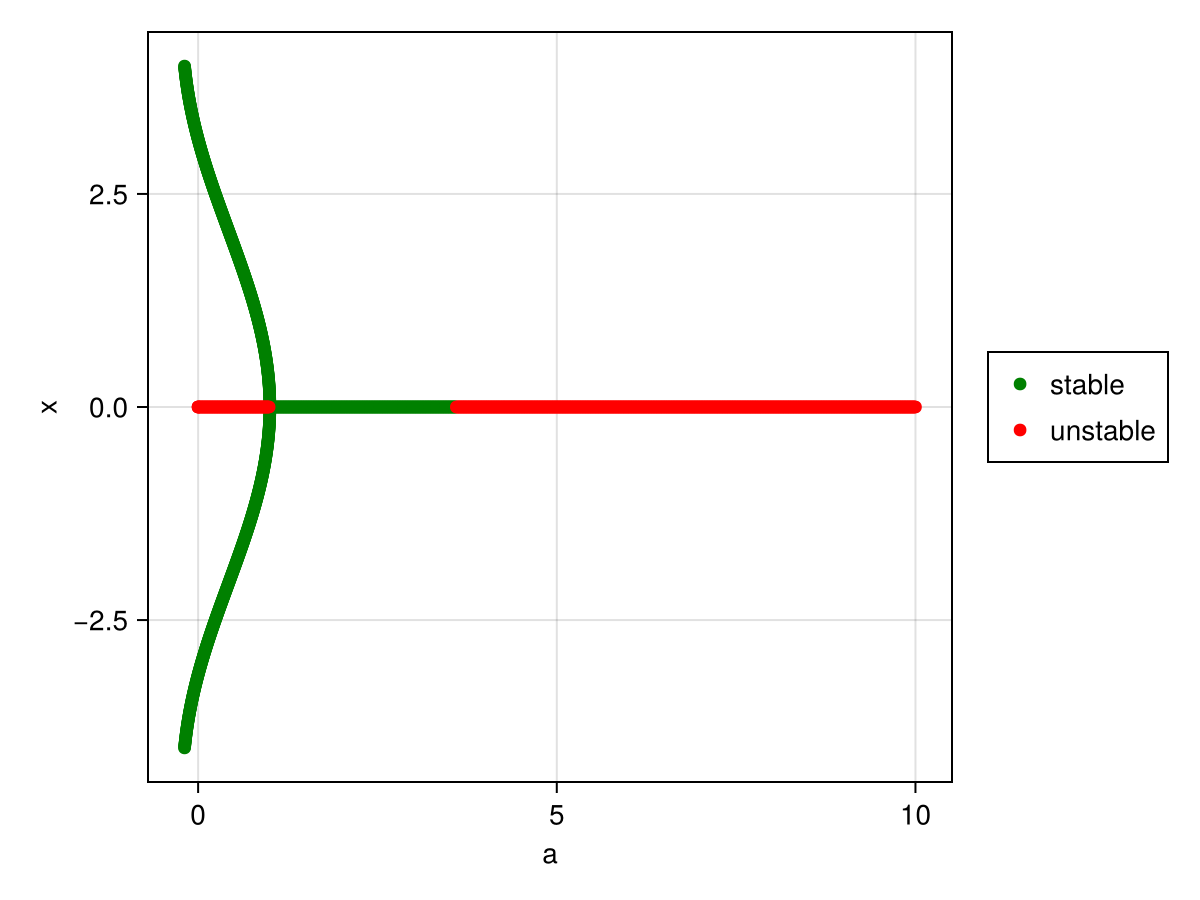

In [80]:
xmat1=hcat([u[1] for u in ylist1],[u[2] for u in ylist1]) #finds the values of x and v for the first equilibrium branch
xlist1=[xmat1[i,:] for i in 1:size(xmat1,1)]#creates a vector of vectors of all the first equilibria branch points
xmat2=hcat([u[1] for u in ylist2],[u[2] for u in ylist2]) #finds the values of x and v for the second equilibrium branch
xlist2=[xmat2[i,:] for i in 1:size(xmat2,1)]#creates a vector of vectors of all the second equilibria branch points
xmat3=hcat([u[1] for u in ylist3],[u[2] for u in ylist3]) #finds the values of x and v for the third equilibrium branch
xlist3=[xmat3[i,:] for i in 1:size(xmat3,1)]#creates a vector of vectors of all the third equilibria branch points

plist1=[u[3] for u in ylist1] #A vector of the values of a for the first equilibrium branch
plist2=[u[3] for u in ylist2] #A vector of the values of a for the second equilibrium branch
plist3=[u[3] for u in ylist3] #A vector of the values of a for the third equilibrium branch

xlist=vcat(xlist1,xlist2,xlist3) #combines all the equilibirium points into one vector
plist=vcat(plist1,plist2,plist3) #combines all values of parameter a into one vector

neq=length(plist) #number of equilibrium points we're finding the stability of
stab=fill(NaN,neq)

for i in 1:neq
    stab[i]=stab_func(invpend_1delay,inpend1tau,xlist[i],[plist[i]],[a,b,tau],[1],nd,doprint=0) #returns stability of the equilibiria (Outputs 1 for stable and 0 for unstable)
end 

stable=(stab.==1.0)#highlights indices of stable points (indicated by a 1 in stable vector)
unstable=(stab.==0.0)#highlights indices of unstable points (indicated by a 1 in unstable vector)

#Below plots the equilibria and shows their stability
fig2=Figure()
ax2=Axis(fig2[1,1],xlabel="a",ylabel="x")
scatter!(ax2,plist[stable],[u[1] for u in xlist[stable]],label="stable",color="green")
scatter!(ax2,plist[unstable],[u[1] for u in xlist[unstable]],label="unstable",color="red")
Legend(fig2[1,2], ax2, merge=true)
fig2

# Hopf Bifurcation

The eigenvalues of the linearised system determine the equilibrium's stability. A Hopf bifurcation occurs when the stability behaviour changes and a pair of complex conugate eigenvalues of the linearised system crosses the imaginary axis and become purely imaginary, i.e. λ=±ω. We start finding the Hopf parameters by finding the initial guess of the ```a``` value for the Hopf bifurcation: 

In [81]:
stab_indx=findfirst(isequal(1.0),stab)#finds where stability changes first time
unstab2_indx=findfirst(isequal(0.0),stab[stab_indx+1:end]) #finds where stability changes again
hopf_indx=stab_indx+unstab2_indx #index of the initial guess where hopf bifurcation is
plist[hopf_indx] #parameter guess for hopf bifurcation

3.5999999999999672

In [82]:
yh01,fhopf=create_hopffunc(invpend_1delay,inpend1tau,[a,b,tau],xlist[hopf_indx],[plist[hopf_indx]],[1],nd) #outputs initial guess of the Hopf bifurcation (including x, ω and a estimates) and a function that contians the method/formula to find the Hopf bifurcation
println("The initial guess for Hopf info: $yh01")
yh1,conv1,=newton_new(fhopf,yh01) #putting initial guess and Hopf function into newton we get the true parameter values and information for the Hopf bifurcation
println("The true information for the Hopf bifurcation: $yh1")
println("converged?: $conv1")
a_hopf=yh1[end]
om_hopf=yh1[end-1]
x_hopf=yh1[1]
println("The a value for hopf bifurcation: $a_hopf")
println("The ω value for hopf bifurcation: $om_hopf") #1.8910.. which is about 0.6π

The initial guess for Hopf info: [0.0, 0.0, 0.0004367101762393604, 0.8838722840593515, -0.46772812055287755, 0.0, 1.8897121526196399, 3.5999999999999672]
The true information for the Hopf bifurcation: [0.0, 0.0, 9.543458061536576e-5, 0.8840075184102647, -0.46747263632951647, 0.00018047021413430053, 1.8910358590211407, 3.5908064152889514]
converged?: true
The a value for hopf bifurcation: 3.5908064152889514
The ω value for hopf bifurcation: 1.8910358590211407


# Pitchfork bifurcation

In [83]:
y0f1,ffold1=create_foldfunc(invpend_1delay,inpend1tau,[a,b,tau],[0.0,0],[1.4],[1],1) #returns initial guess for the fold parameters and a function that contains the formula for finding a fold
yff1,convf1,=newton_new(ffold1,y0f1) #finds value of a for fold for fixed b=1.5

a_fold=yff1[end]
x_fold=yff1[1]

println("The information for the fold bifurcation: $yff1")
println("The value of 'a' that a fold occurs at is: $a_fold")

The information for the fold bifurcation: [0.0, 0.0, -1.0, 1.4035380228092525e-25, 0.0, 0.0, 0.9999999999833333]
The value of 'a' that a fold occurs at is: 0.9999999999833333


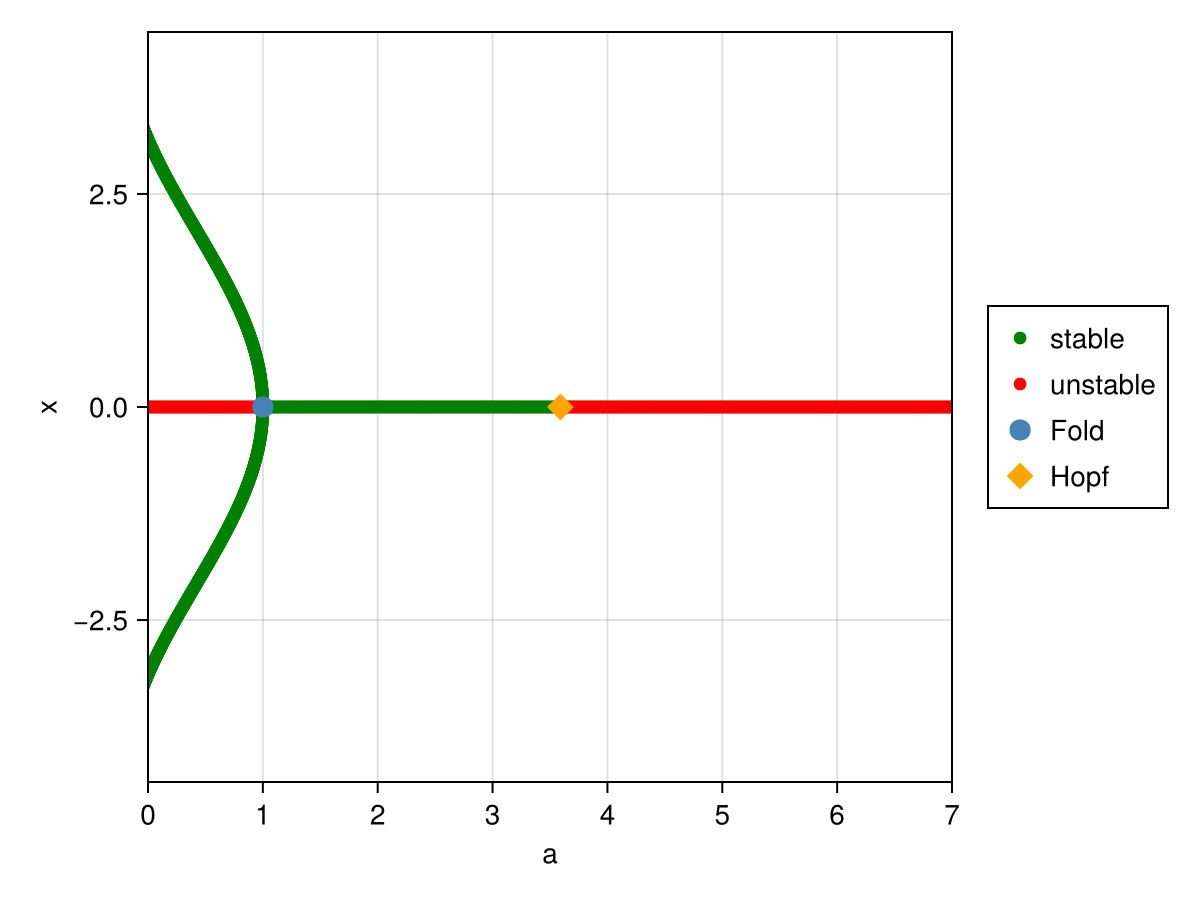

In [84]:
fig3=Figure()
ax3=Axis(fig3[1,1],xlabel="a",ylabel="x")
scatter!(ax3,plist[stable],[u[1] for u in xlist[stable]],label="stable",color="green")
scatter!(ax3,plist[unstable],[u[1] for u in xlist[unstable]],label="unstable",color="red")
scatter!(ax3,a_fold, x_fold, label="Fold", color=:steelblue, marker=:circle, markersize=:15)
scatter!(ax3,a_hopf, x_hopf, label="Hopf", color=:orange, marker=:diamond, markersize=:15)
Legend(fig3[1,2], ax3, merge=true)
xlims!(ax3,[0.0,7])
fig3

While this code produces an ```a``` value for a fold bifurcation, however, the bifurcation at ```a```=1 is actually a pitchfork bifurcation (rather than a fold bifurcation) due to the reflection symmetry.

# Continutation over (a,b)-plane

We continue the bifurcation points in the ```a``` and ```b``` parameter plane:

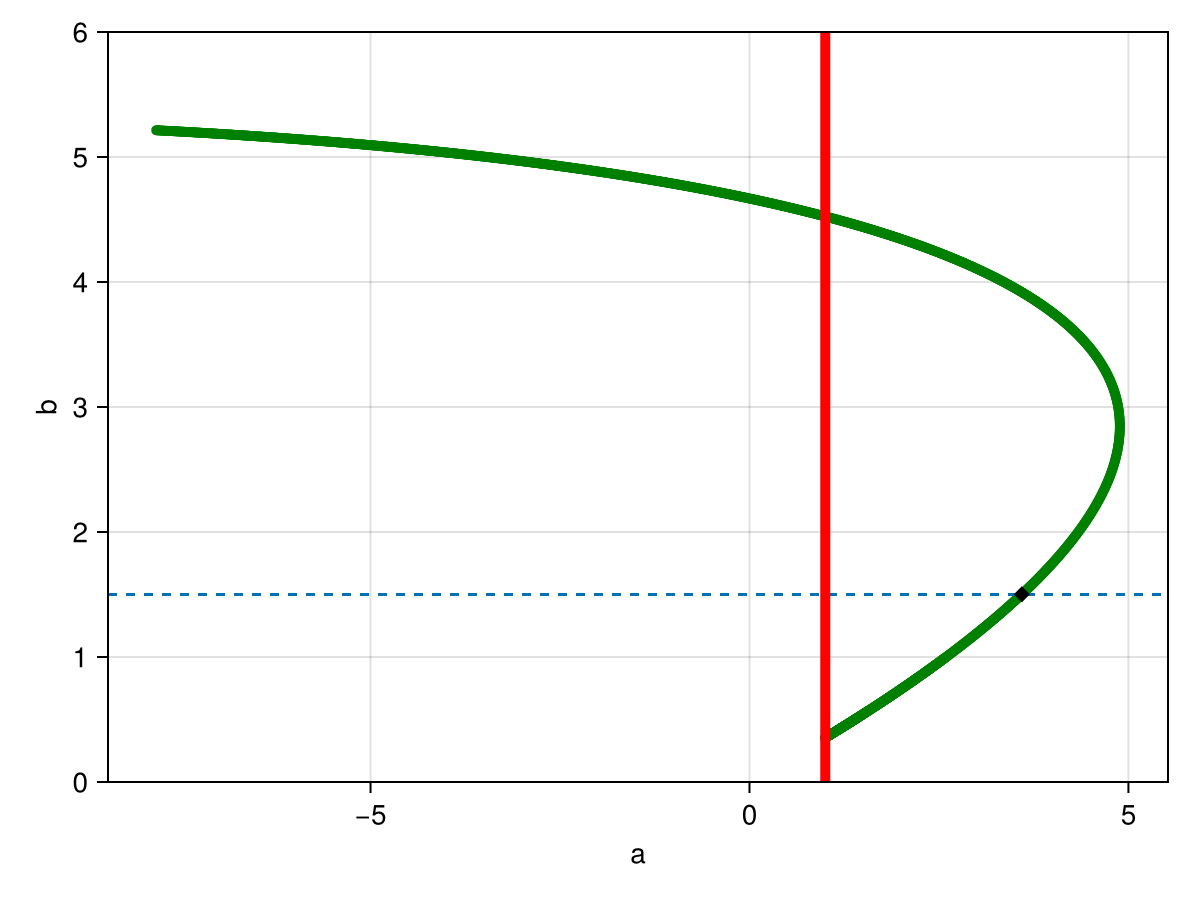

In [85]:
yheq01,fhopfeq1=create_hopffunc(invpend_1delay,inpend1tau,[a_hopf,0,tau],[0.0,0],[a_hopf,0],[1,2],nd) #initialises hopf function and initial guess for a≈3.59 and b=0
yheqlist1,heqtan1=track_curve_new(fhopfeq1,yheq01,[0.0,0,0,0,0,0,0,-1,-1],nmax=2000) #tracks over a and b plane

#Below marks the Hopf bifurcation for fixed b=1.5
a_vals=[u[end-1] for u in yheqlist1]
b_vals=[u[end] for u in yheqlist1]
b1_5indx=argmin(abs.([u[end] for u in yheqlist1].-1.5))
a1=a_vals[b1_5indx]
b1=b_vals[b1_5indx]

#Plot of continuation/tracking in (a,b) plane
fig4=Figure()
ax4=Axis(fig4[1,1],xlabel="a",ylabel="b")
scatter!(ax4,[u[end-1] for u in yheqlist1[2:end]],[u[end] for u in yheqlist1[2:end]],color="green",markersize=:7)
hlines!(ax4,1.5,linestyle=:dash)
scatter!(ax4,a1,b1,marker=:diamond,color=:black) # Hopf bifurcation for fixed b=1.5
vlines!(ax4,1,linestyle=:solid, linewidth=:5,color=:red) #red line represents the fact that a pitchfork bifurcation occurs at a=1 for all b values
ylims!(ax4,[0,6])
fig4

We'll look at the behaviour of the bifurcation points for τ=sqrt(2):

In [86]:
tau_trial2=sqrt(2)
yheq02,fhopfeq2=create_hopffunc(invpend_1delay,inpend1tau,[0,0,tau_trial2],[0.0,0],[0.0,0],[1,2],nd) #initialises hopf function and initial guess for a≈3.59 and b=0
yheqlist2,heqtan2=track_curve_new(fhopfeq2,yheq02,[0.0,0,0,0,0,0,0,1,1],nmax=2000) #tracks over a and b plane

#Plot of continuation/tracking in (a,b) plane
fig5=Figure()
ax5=Axis(fig5[1,1],xlabel="a",ylabel="b")
scatter!(ax5,[u[end-1] for u in yheqlist2[2:end]],[u[end] for u in yheqlist2[2:end]],color="green",markersize=:7)
#hlines!(ax5,1.5,linestyle=:dash)
#scatter!(ax5,a1,b1,marker=:diamond,color=:black) # Hopf bifurcation for fixed b=1.5
vlines!(ax5,1,linestyle=:solid, linewidth=:5,color=:red) #red line represents the fact that a pitchfork bifurcation occurs at a=1 for all b values
ylims!(ax5,[0,6])
fig5

SingularException: SingularException(9)

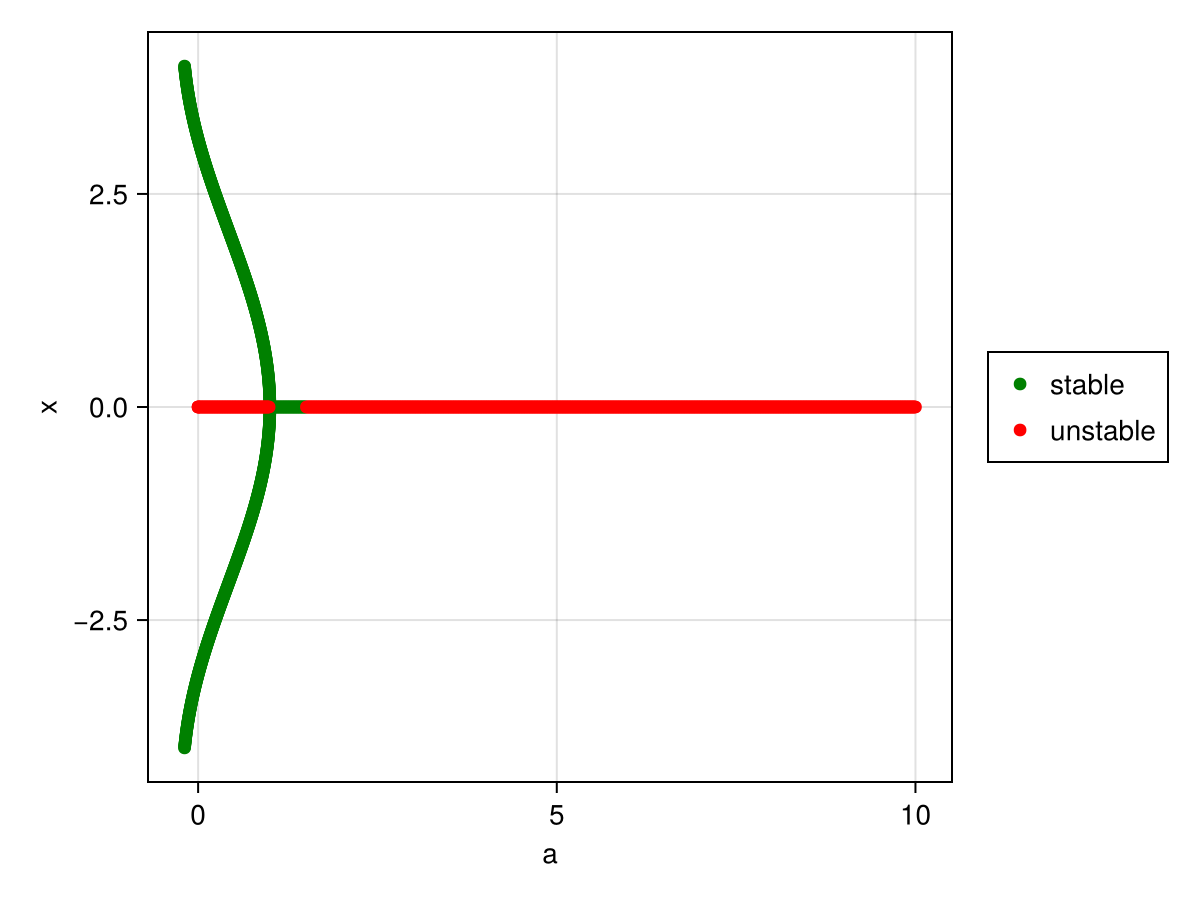

In [87]:
tau_trial2=0.75#sqrt(2)
a=0.0 #parameter a - starts at 0 as this is the parameter we're varying over
b=1.5 #parameter b - fixed 
nd=1 #number of delays (single delay so nd=1)

#Now we looking at finding the equilibria branches
y02,f_equ2=F_eq(invpend_1delay,[0.0,0],[a,b,tau_trial2],nd,par_indx=1)#nd=1,pars_indx=1 as parameter a (the parameter we're varying) is the first parameter
#The above ouputs the initial guess for x,v and parameter 'a' and the equilibrium function

ylist11,ytan11=track_curve_new(f_equ2,y02,[0.0,0,1],nmax=1000) #initial tangent changes a (initial tangent=[0.0,0,1])
ylist21,ytan21=track_curve_new(f_equ2,y02,[1.0,0,0],nmax=400) #initial tangent changes x with initial tangent in postive x direction
ylist31,ytan31=track_curve_new(f_equ2,y02,[-1.0,0,0],nmax=400) #initial tangent changes x with initial tangent in negative x direction

#Now we look at stability of the steady-state branches
xmat11=hcat([u[1] for u in ylist11],[u[2] for u in ylist11])
xlist11=[xmat11[i,:] for i in 1:size(xmat11,1)]
xmat21=hcat([u[1] for u in ylist21],[u[2] for u in ylist21])
xlist21=[xmat21[i,:] for i in 1:size(xmat21,1)]
xmat31=hcat([u[1] for u in ylist31],[u[2] for u in ylist31])
xlist31=[xmat31[i,:] for i in 1:size(xmat31,1)]

plist11=[u[3] for u in ylist11]
plist21=[u[3] for u in ylist21]
plist31=[u[3] for u in ylist31]

xlist111=vcat(xlist11,xlist21,xlist31)
plist111=vcat(plist11,plist21,plist31)

neq2=length(plist111) #number of equilibrium points we're finding the stability of
stab2=fill(NaN,neq2)

for i in 1:neq2
    stab2[i]=stab_func(invpend_1delay,inpend1tau,xlist111[i],[plist111[i]],[a,b,tau_trial2],[1],nd,doprint=0)
end 


stable2=(stab2.==1.0)
unstable2=(stab2.==0.0)

fig5=Figure()
ax5=Axis(fig5[1,1],xlabel="a",ylabel="x")
scatter!(ax5,plist111[stable2],[u[1] for u in xlist111[stable2]],label="stable",color="green")
scatter!(ax5,plist111[unstable2],[u[1] for u in xlist111[unstable2]],label="unstable",color="red")
Legend(fig5[1,2], ax5, merge=true)
fig5


In [88]:
stab_indx2=findfirst(isequal(1.0),stab2)#finds where stability changes first time
unstab2_indx2=findfirst(isequal(0.0),stab2[stab_indx2+1:end]) # finds where stability changes again 
hopf_indx2=stab_indx2+unstab2_indx2 #index of initial guess of where hopf bifurcation is
plist111[hopf_indx2] #parameter guess for hopf bifurcation

1.5100000000000011

In [89]:
include("create_hopffunc.jl")
yh02,fhopf2=create_hopffunc(invpend_1delay,inpend1tau,[a,b,tau_trial2],xlist111[hopf_indx2],[plist111[hopf_indx2]],[1],nd)
println("The initial guess for Hopf info: $yh02")
yh2,conv2,=newton_new(fhopf2,yh02)
println("The true information for the Hopf bifurcation: $yh2")
println("converged?: $conv2")
a_hopf2=yh2[end]
om_hopf2=yh2[end-1]
x_hopf2=yh2[1]
println("The a value for hopf bifurcation: $a_hopf2")
println("The ω value for hopf bifurcation: $om_hopf2") #1.8910.. which is about 0.6π

The initial guess for Hopf info: [0.0, 0.0, -0.0003533381231675334, -0.7449273298459792, 0.6671455226565719, 0.0, 1.1165886535882539, 1.5100000000000011]
The true information for the Hopf bifurcation: [0.0, 0.0, -0.00015657988471071602, -0.7462279938480904, 0.6656904129335981, -0.00017552347303565263, 1.120983537316656, 1.504959407607236]
converged?: true
The a value for hopf bifurcation: 1.504959407607236
The ω value for hopf bifurcation: 1.120983537316656


In [90]:
yheq02,fhopfeq2=create_hopffunc(invpend_1delay,inpend1tau,[a_hopf2,0,tau_trial2],[0.0,0],[a_hopf2,0],[1,2],nd)
yheqlist2,heqtan2=track_curve_new(fhopfeq2,yheq02,[0.0,0,0,0,0,0,0,-1,-1],nmax=2000)

#Below marks the Hopf bifurcation for fixed b=1.5
a_vals2=[u[end-1] for u in yheqlist2]
b_vals2=[u[end] for u in yheqlist2]
b1_5indx2=argmin(abs.([u[end] for u in yheqlist2].-1.5))

a12=a_vals2[b1_5indx2]
b12=b_vals2[b1_5indx2]

#Plot of continuation/tracking in (a,b) plane
fig6=Figure()
ax6=Axis(fig6[1,1],xlabel="a",ylabel="b")
scatter!(ax6,[u[end-1] for u in yheqlist2[2:end]],[u[end] for u in yheqlist2[2:end]],color="green",markersize=:7)
hlines!(ax6,1.5,linestyle=:dash)
scatter!(ax6,a12,b12,marker=:diamond,color=:black)
vlines!(ax6,1,linestyle=:solid, linewidth=:5,color=:red)
ylims!(ax6,[0,6])
fig6

SingularException: SingularException(1)

In [91]:
xlist[1003]

2-element Vector{Float64}:
 0.01
 0.0